1. Euclidian distance function [4 points]
============
The squared Euclidean distance between two D-dimensional vectors x and z is given by
$\newcommand{\norm}[1]{\left\lVert#1\right\rVert}$

$\norm{\mathbf{x} - \mathbf{z}}_{2}^{2} = (\mathbf{x} - \mathbf{z})^\top(\mathbf{x} - \mathbf{z}) = \sigma_{d=1}^{D}(X_d - Z_d)^2$

In [3]:
import tensorflow as tf;
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

In [4]:
def euclidianDist(a, b):
    x_z = (tf.expand_dims(a,0) - tf.expand_dims(b,1))
    return tf.transpose(tf.reduce_sum(tf.multiply(x_z, x_z), 2))

# Alternative Solution
# def distanceFunc(X, Z):
#    return tf.reduce_sum((tf.expand_dims(X, 2) - tf.expand_dims(tf.transpose(Z), 0))**2, 1)

a = np.array([[0,0],[0,1],[0,2]])
b = np.array([[1,0],[1,1],[1,2],[1,3],[1,4]])

print('a = ')
print(a)
print('b = ')
print(b)
print('Distance Matrix = ')
print(sess.run(euclidianDist(a,b)))

a = 
[[0 0]
 [0 1]
 [0 2]]
b = 
[[1 0]
 [1 1]
 [1 2]
 [1 3]
 [1 4]]
Distance Matrix = 
[[ 1  2  5 10 17]
 [ 2  1  2  5 10]
 [ 5  2  1  2  5]]


2. Making Predictions for Regression [6 points]
============
### Data Setup

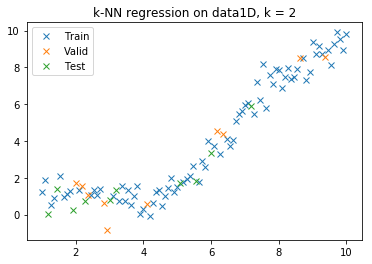

In [5]:
# Generating Data
k = 2

np.random.seed(521)
Data = np.linspace(1.0 , 10.0 , num =100) [:, np. newaxis]
Target = np.sin( Data ) + 0.1 * np.power( Data , 2) \
         + 0.5 * np.random.randn(100 , 1)
randIdx = np.arange(100)
np.random.shuffle(randIdx)
trainData, trainTarget = Data[randIdx[:80]], Target[randIdx[:80]]
validData, validTarget = Data[randIdx[80:90]], Target[randIdx[80:90]]
testData, testTarget = Data[randIdx[90:100]], Target[randIdx[90:100]]

# Draw the plot
line = plt.figure()
plt.title('k-NN regression on data1D, k = ' + str(k))
plt.plot(trainData, trainTarget, "x")
plt.plot(validData, validTarget, "x")
plt.plot(testData, testTarget, "x")
plt.legend(['Train', 'Valid', 'Test'])
plt.show()

### 2.1 Choosing the nearest neighbours [2 points]

In [6]:
# def pickKNearest(Distance, K=50):
#      numTrainData = tf.shape(Distance)[1]
#      dist_k, ind_k = tf.nn.top_k(-Distance, k = K)
#      R = tf.reduce_sum(tf.to_float(tf.equal(tf.expand_dims(ind_k,2),
#                               tf.reshape(tf.range(numTrainData), [1,1,-1]))),1)
#      return R/tf.to_float(K)

def pickKNearestNeighboursUnscaled(DistMatrix, k):
    length = tf.shape(DistMatrix)[1]
    
    values, indices = tf.nn.top_k(-DistMatrix, k)
    range = tf.range(length)
    
    rangeblock = tf.expand_dims(tf.expand_dims(range, 0),0)
    indexblock = tf.expand_dims(indices, 2)
    
    truth_matrix = tf.reduce_sum(tf.to_float(tf.equal(rangeblock, indexblock)),1)

    return truth_matrix

def pickKNearestNeighbours(DistMatrix, k):
    length = tf.shape(DistMatrix)[1]
    
    values, indices = tf.nn.top_k(-DistMatrix, k)
    range = tf.range(length)
    
    rangeblock = tf.expand_dims(tf.expand_dims(range, 0),0)
    indexblock = tf.expand_dims(indices, 2)
    
    truth_matrix = tf.reduce_sum(tf.to_float(tf.equal(rangeblock, indexblock)),1)

    return truth_matrix / tf.to_float(k)

print(sess.run(pickKNearestNeighbours(euclidianDist(a,b),3)))


[[0.33333334 0.33333334 0.33333334 0.         0.        ]
 [0.33333334 0.33333334 0.33333334 0.         0.        ]
 [0.         0.33333334 0.33333334 0.33333334 0.        ]]


### 2.2 Prediction [4 points]

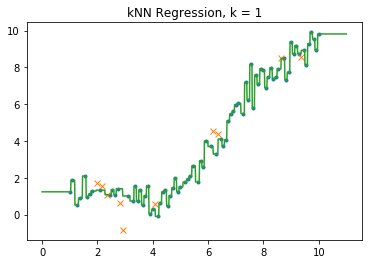

(K = 1)	MSE values: Valid = 0.5430993, Test = 0.622008, Train = 0.0


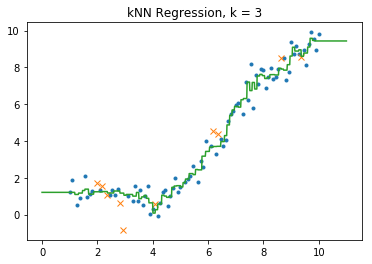

(K = 3)	MSE values: Valid = 0.6525566, Test = 0.29018393, Train = 0.21048422


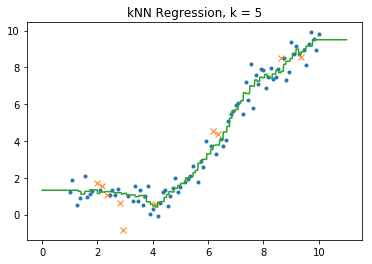

(K = 5)	MSE values: Valid = 0.6208772, Test = 0.35665315, Train = 0.23708253


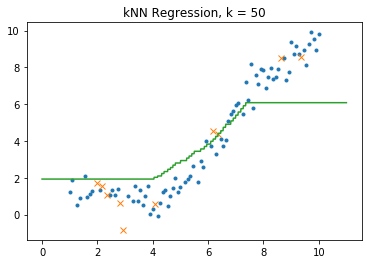

(K = 50)	MSE values: Valid = 2.4574032, Test = 1.4138691, Train = 2.4960175
Value of K for lowest MSE in valid data set is 1


In [7]:

def predictFinalValue(inputX, trainX, trainY, K):
    Knearest = pickKNearestNeighbours(euclidianDist(inputX, trainX), K)
    return tf.matmul(Knearest, trainY)

# The number of nearest neighbours
K = tf.placeholder(tf.int32, name='K')

# The X and Y of the input that the data recieves
trainX = tf.placeholder(tf.float32, [None, 1])
trainY = tf.placeholder(tf.float32, [None, 1])

# K nearest takes the new test input X. Finds the K nearest matrix and multiplies with the training Y output
inputX = tf.placeholder(tf.float32, [None, 1]) # The X that we want to find a predicted Y
inputY = tf.placeholder(tf.float32, [None, 1]) # The actual correct value for Y

predictedY = predictFinalValue(inputX, trainX, trainY, K)

# Mean Squared Error Loss
MSE = tf.reduce_mean(tf.reduce_sum((predictedY - inputY) ** 2, 1))


## Training Tests
k_list = [1,3,5,50]
MSEValid_list = []
MSETest_list = []

PreciseX = np.linspace(0.0, 11.0, num = 1000)[:, np.newaxis]

for k in k_list:
    # Valid
    PredYvalid, MSEvalid = sess.run([predictedY, MSE], feed_dict={
        trainX:trainData,
        trainY:trainTarget,
        inputX:validData,
        inputY:validTarget,
        K:k})
    MSEValid_list.append(MSEvalid)
    
    # Test
    PredYtest, MSEtest = sess.run([predictedY, MSE], feed_dict={
        trainX:trainData,
        trainY:trainTarget,
        inputX:testData,
        inputY:testTarget,
        K:k})
    MSETest_list.append(MSEtest)
    
    # Train
    PredYtrain, MSEtrain = sess.run([predictedY, MSE], feed_dict={
        trainX:trainData,
        trainY:trainTarget,
        inputX:trainData,
        inputY:trainTarget,
        K:k})
    
    # All
    PredYall, MSEall = sess.run([predictedY, MSE], feed_dict={
        trainX:trainData,
        trainY:trainTarget,
        inputX:Data,
        inputY:Target,
        K:k})
    
    # X input
    PredYprecise = sess.run(predictedY, feed_dict={
        trainX:trainData,
        trainY:trainTarget,
        inputX:PreciseX,
        K:k})
    
    # Draw the Plot
    plt.figure(k)
    plt.plot(trainData,trainTarget,".")
    plt.plot(validData,validTarget,"x")
    plt.plot(PreciseX,PredYprecise,"-")
    plt.title("kNN Regression, k = %d"%k)
    plt.show()
    
    # MSE Information
    print('(K = ' + str(k) + ')\tMSE values: Valid = ' + str(MSEvalid) + ', Test = ' + str(MSEtest) + ', Train = ' + str(MSEtrain))

MSEvalidbestindex = np.argmin(MSEValid_list)
Kbest = k_list[MSEvalidbestindex]
print("Value of K for lowest MSE in valid data set is " + str(Kbest))

3. Making Predictions for Classification [10 points]
============
### Data Setup

In [20]:
def data_segmentation(data_path, target_path, task):
    # task = 0 >> select the name ID targets for face recognition task
    # task = 1 >> select the gender ID targets for gender recognition task data = np.load(data_path)/255
    data = np.load(data_path)/255
    data = np.reshape(data, [-1, 32*32])
    
    target = np.load(target_path)
    np.random.seed(45689)
    rnd_idx = np.arange(np.shape(data)[0])
    np.random.shuffle(rnd_idx)
    trBatch = int(0.8*len(rnd_idx))
    validBatch = int(0.1*len(rnd_idx))
    trainData, validData, testData = data[rnd_idx[1:trBatch],:], \
                                   data[rnd_idx[trBatch+1:trBatch + validBatch],:],\
                                   data[rnd_idx[trBatch + validBatch+1:-1],:]
    trainTarget, validTarget, testTarget = target[rnd_idx[1:trBatch], task], \
                              target[rnd_idx[trBatch+1:trBatch + validBatch], task],\
                              target[rnd_idx[trBatch + validBatch + 1:-1], task]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

trainData, validData, testData, trainTarget, validTarget, testTarget = data_segmentation('data.npy', 'target.npy', 1)
runCount = testData.shape[0]


### Predicting Class Label [4 pts]

In [27]:
def predictFinalValue(inputX, trainX, trainY, K):
    Knearest = pickKNearestNeighboursUnscaled(euclidianDist(inputX, trainX), K)
    predictionMatrix = tf.multiply(Knearest, trainY + 1)

    outputY = tf.zeros(0)    
    for i in range(0, runCount):
        y, idx, count = tf.unique_with_counts(predictionMatrix[i])
        count2 = tf.slice(count, [1], tf.shape(count)-1)
        item_class = tf.expand_dims(y[tf.argmax(count2)+1],0)
        outputY = tf.concat([outputY, item_class],0)
    
    outputY = outputY - 1
    return tf.to_int32(outputY)

def getPredictionMatrix(inputX, trainX, trainY, K):
    Knearest = pickKNearestNeighboursUnscaled(euclidianDist(inputX, trainX), K)
    predictionMatrix = tf.multiply(Knearest, trainY + 1)

    return predictionMatrix

# Tensorflow inputs
inputX = tf.placeholder(tf.float32, [None, 32*32])
inputY = tf.placeholder(tf.float32, [None])
trainX = tf.placeholder(tf.float32, [None, 32*32])
trainY = tf.placeholder(tf.float32, [None])
K = tf.placeholder(tf.int32, name='K')

predictY = predictFinalValue(inputX, trainX, trainY, K)
predictionMatrix = getPredictionMatrix(inputX, trainX, trainY, K)
accuracy = tf.reduce_sum(tf.to_int32(tf.equal(predictY, tf.to_int32(inputY))))
correctness = tf.to_int32(tf.equal(predictY, tf.to_int32(inputY)))

### Face Recognition using k-NN [4 pts]

In [17]:
k_list = [1, 5, 10, 25, 50, 100, 200]

# Validation Set
for k in k_list:
    runCount = validData.shape[0]
    prediction, error = sess.run([predictY, accuracy], feed_dict={
        trainX:trainData,
        trainY:trainTarget,
        inputX:validData,
        inputY:validTarget,
        K:k
        })
    print(prediction)
    print("K = " + str(k) + " Correctly Classified: " + str(error) + "/" + str(runCount))
    
#     j = 0;
#     for i in range(0, runCount):
#         plt.figure(figsize = (1,2))
#         img = np.reshape(validData[i], (32, 32))
#         plt.imshow(img, interpolation='nearest')
#         plt.title("K = " + str(k) + ": Img " + str(i) + " Predicted: " + str(prediction[i]) + " Actual: " + str(validTarget[i]))
#         plt.show()



InvalidArgumentError: slice index 92 of dimension 0 out of bounds.
	 [[Node: strided_slice_375 = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Mul_8, strided_slice_375/stack, strided_slice_375/stack_1, strided_slice_375/stack_2)]]

Caused by op 'strided_slice_375', defined at:
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-173e439618ab>", line 28, in <module>
    predictY = predictFinalValue(inputX, trainX, trainY, K)
  File "<ipython-input-14-173e439618ab>", line 7, in predictFinalValue
    y, idx, count = tf.unique_with_counts(predictionMatrix[i])
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 538, in _SliceHelper
    name=name)
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 706, in strided_slice
    shrink_axis_mask=shrink_axis_mask)
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5430, in strided_slice
    name=name)
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/Users/vuwij/anaconda/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): slice index 92 of dimension 0 out of bounds.
	 [[Node: strided_slice_375 = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Mul_8, strided_slice_375/stack, strided_slice_375/stack_1, strided_slice_375/stack_2)]]


In [11]:
# Test Set
for k in k_list:
    runCount = testData.shape[0]
    prediction, error = sess.run([predictY, accuracy], feed_dict={
        trainX:trainData,
        trainY:trainTarget,
        inputX:testData,
        inputY:testTarget,
        K:k
        })
    print(prediction)
    print("K = " + str(k) + " Correctly Classified: " + str(error) + "/" + str(runCount))
    

[1 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0 0 1 0 1 0
 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0
 0 0 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0]
K = 1 Correctly Classified: 86/93
[1 1 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1
 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0
 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 0]
K = 5 Correctly Classified: 84/93
[1 1 0 1 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1
 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0
 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 0]
K = 10 Correctly Classified: 82/93
[1 1 0 1 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1
 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0
 0 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0 0 0]
K = 25 Correctly Classified: 82/93
[1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1
 0 0 0 1 0 1 0 0 1 1 1 0 1 

[1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0
 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 

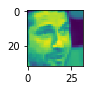

56


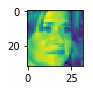

69


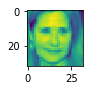

79


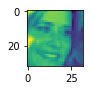

247


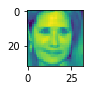

304


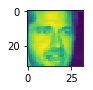

332


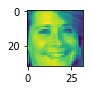

436


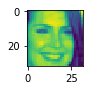

546


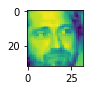

591


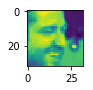

609


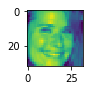

In [28]:
# Test Set
runCount = testData.shape[0]
predictionMatrix, correctness = sess.run([predictionMatrix, correctness], feed_dict={
    trainX:trainData,
    trainY:trainTarget,
    inputX:testData,
    inputY:testTarget,
    K:10
    })
print(correctness)
print(predictionMatrix[1,:])

# Image with index 1 is incorrect
plt.figure(figsize = (1,2))
img = np.reshape(testData[1], (32, 32))
plt.imshow(img, interpolation='nearest')
plt.show()

# Closest 10 values
closest10 = np.nonzero(predictionMatrix[1,:])
for i in range(0,10):
    plt.figure(figsize = (1,2))
    print(closest10[0][i])
    img = np.reshape(trainData[closest10[0][i]], (32, 32))
    plt.imshow(img, interpolation='nearest')
    plt.show()

# print(predictionMatrix.eval())
